In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2
swyft.set_verbosity(5)

In [2]:
DEVICE = 'cuda:0'

In [3]:
def model(params, sigma = .1):
    z = np.array(list(params.values()))
    x = np.abs(z-0.5)*2  # 0 ... 1
    return dict(x=x)

In [4]:
def noise(obs, params, sigma = 0.1):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [5]:
zdim=50
params = ["z"+str(i) for i in range(zdim)]
par0 = {k: 0.25 for k in params}
obs0 = noise(model(par0), par0)
obs1=model(par0)  # Asimov data

In [6]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in params})

In [9]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 10000, Nmax=20000)

Creating new cache.


In [10]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

NRE round: R = 1
Number of training samples is N_R = 10000
Additional simulations are required after growing the cache.
Simulate:   0%|          | 6/9764 [00:00<03:01, 53.74it/s]

  adding 9764 new samples to simulator cache.


Simulate: 100%|██████████| 9764/9764 [03:03<00:00, 53.34it/s]
Starting neural network training.
Entering trainloop
lr: 0.001
validation loss = 69.01
validation loss = 62.53
validation loss = 53.24
validation loss = 48.5
validation loss = 46.18
validation loss = 45.76
validation loss = 45.55
validation loss = 45.22
validation loss = 45.56
lr: 0.0001
validation loss = 43.85
validation loss = 43.67
validation loss = 43.83
Train losses: [69.28363727653114, 66.4051244693951, 57.277923876351686, 49.47533532302745, 45.556056962396106, 43.919430823221695, 42.95520749057297, 42.41213962805532, 40.38891321725219, 39.55735693882852]
Valid losses: [69.0053466796875, 62.533504486083984, 53.24421005249023, 48.49786211649577, 46.182268397013345, 45.7585199991862, 45.5511220296224, 45.22259229024251, 43.850890986124675, 43.66952718098958]
Finished trainloop.
constr_prior_R : prior_R volume = 0.04045 : 1


In [26]:
samples = s.marginals(obs1, 1000000)

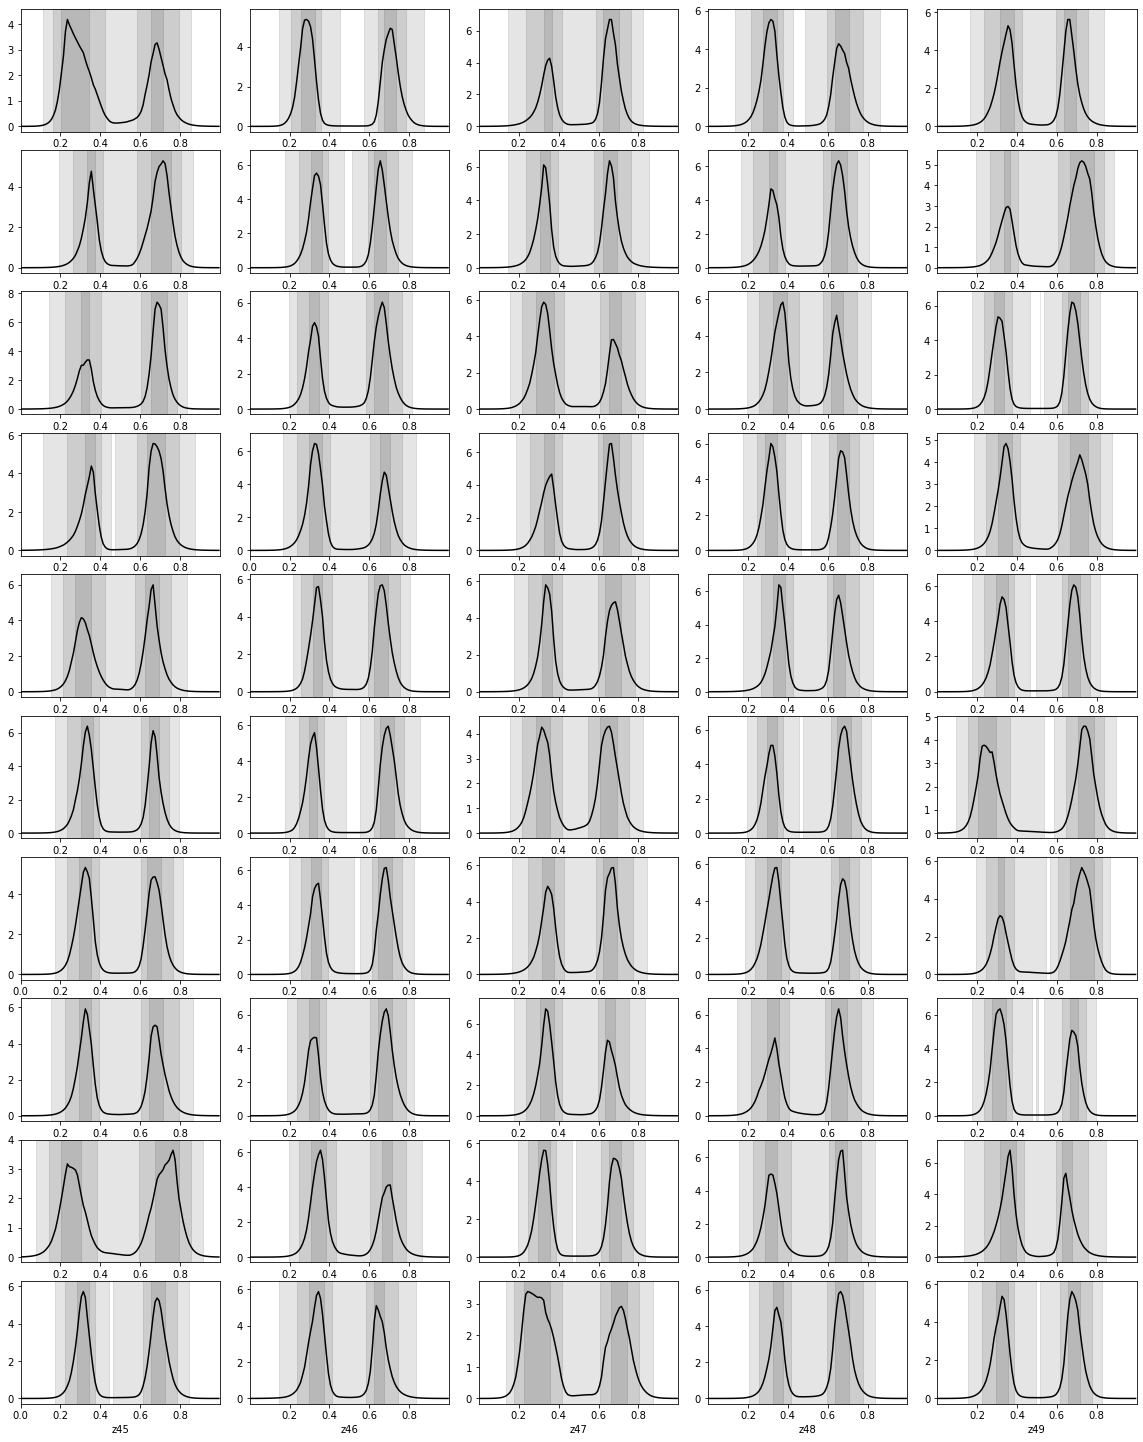

In [27]:
swyft.plot.plot1d(samples, params, figsize = (20, 25), ncol = 5)

In [ ]:
s2 = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 50000, Nmax=20000)
s2.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

In [71]:
samples2 = s2.marginals(obs1, 1000)

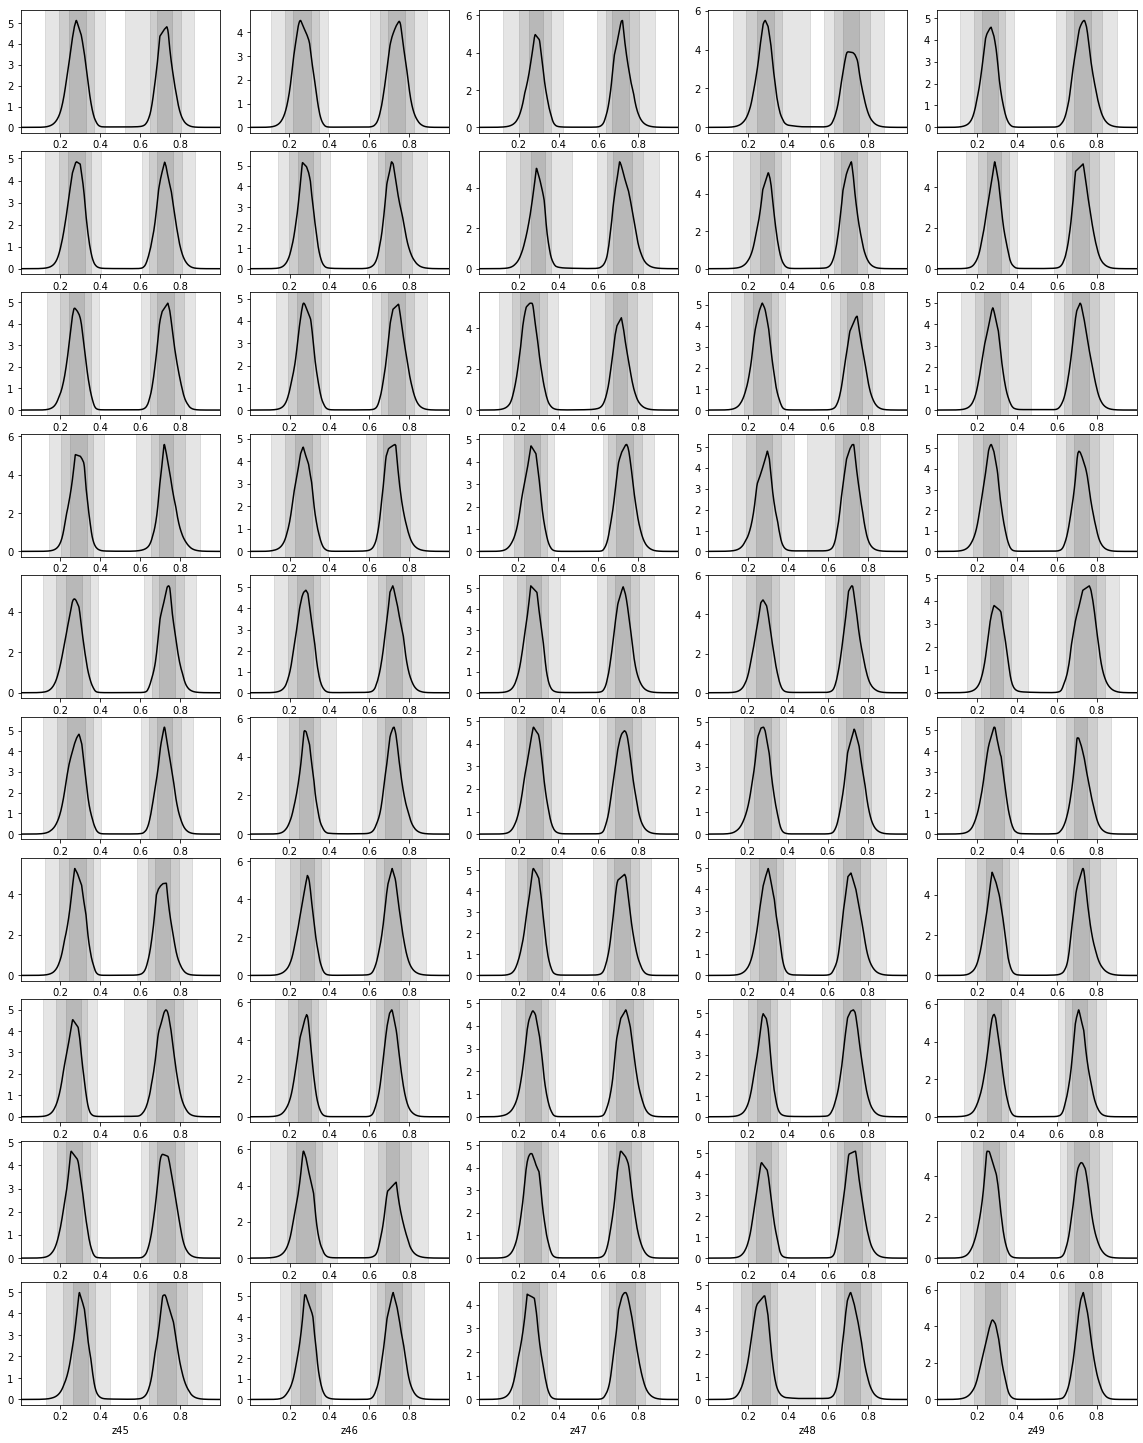

In [72]:
swyft.plot.plot1d(samples2, params, figsize = (20, 25), ncol = 5, grid_interpolate=True)

In [149]:
a = 0.25
par2 = {k: a for k in params}
obs2= model(par2)  # Asimov data

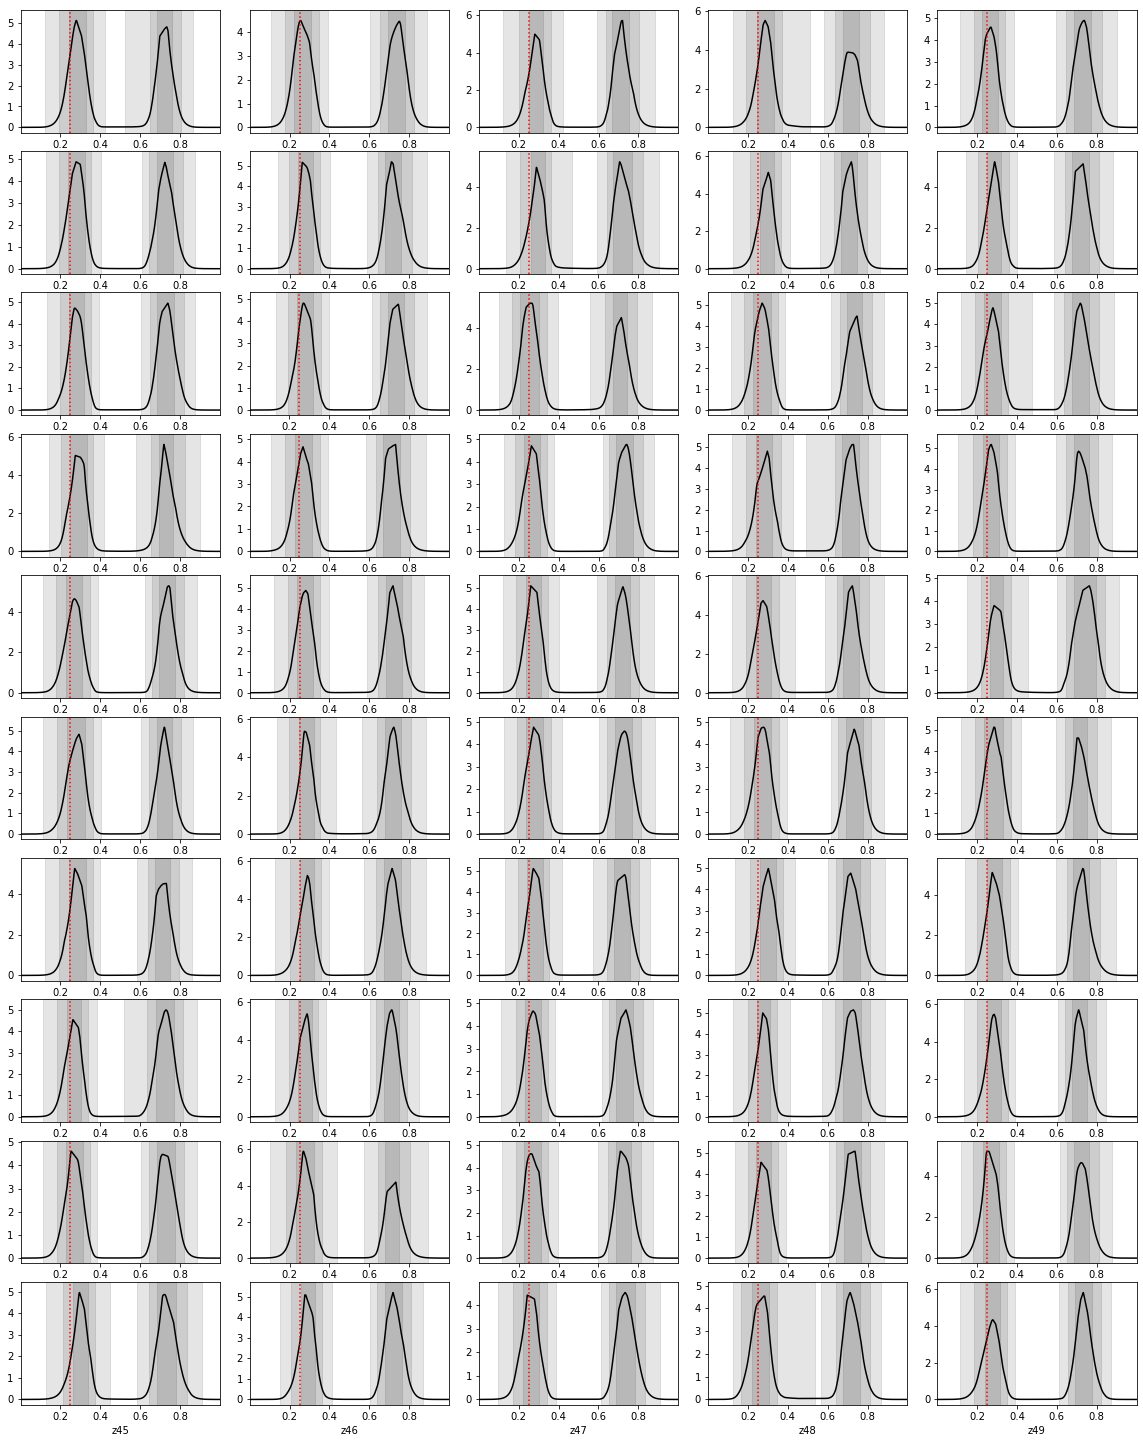

In [150]:
samples3 = s2.marginals(obs2, 3000)
swyft.plot.plot1d(samples3, params, figsize = (20, 25), ncol = 5, grid_interpolate=True, truth = par2)

In [ ]:
from scipy.stats import norm
p = lambda x: 0.5*norm.pdf(x, a, 0.05) + 0.5*norm.pdf(x, 1-a, 0.05)
true_posteriors = {(k,): p for k in params}
diag = swyft.utils.sample_diagnostics(samples3, true_posteriors = true_posteriors, true_params = par2)
plt.hist([v['KL'] for v in diag.values()], range = [0, 2.], bins = 40);